In [1]:
%%capture
!git clone https://github.com/speechbrain/benchmarks.git
%cd benchmarks
!git submodule update --init --recursive
%cd speechbrain
!pip install -r requirements.txt
!pip install -e .
%cd /content/benchmarks/benchmarks/MOABB
!pip install -r ../../requirements.txt    # Install base dependencies
!pip install -r extra-requirements.txt    # Install additional dependencies
%cd /content/benchmarks/benchmarks/MOABB
%env PYTHON_PATH=/content/benchmarks/

## **Abstract**

This project aims to develop a neural network for decoding Motor Imagery from EEG data signals. Although similar research has been conducted in the past, we hope to produce innovative models that have not been tried yet.
The project will be using the SpeechBrain-MOABB library, which will facilitate the integration and evaluation of models throughout the project. The BNCI2014001 EEG dataset will be used to train and evaluate our models.

After an extensive literature review, we had determined 2 important points:
   1. Convolutional Neural Networks shine in tasks of pattern detection (such as EEG signal decoding)
   2. EEG models with 2 convolutional layers are able to perform essentially as well as deeper networks.

With this in mind, we limited our models to having only 2 convolutional layers and focused our attention on pooling methods.
After evaluating our top-performing model, we observed similar accuracies to the EEGNet model. However, our model, having less parameters, was much lighter and faster than EEGNet.


## **Introduction**

The tremendous advancements in Machine Learning in recent years have made it possible to implement AI into various fields. More recently, a strong interest in using Machine Learning models to decode electroencephalogram (EEG) signals led to much research being made in this context. Indeed, reliably decoding EEG signals can pave the way for new inclusive technologies.

\

Previous studies have attempted to develop models that accurately decode motor imagery and have shown promising results. Nonetheless, significant challenges still need to be overcome. Specifically, the non-stationary nature of EEG signals and the noise they contain caps the accuracy of even the best models.[1]

\

The current benchmark that we will be comparing our models to is the EEGNet model. The EEGNet has 3 main convolution layers, with ELU activation and 2D Average Pooling in the last 2 layers


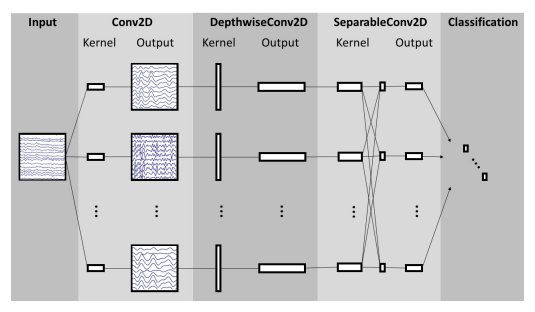

\

Despite its solid accuracy, the EEGNet model still has room to improve, with an overall accuracy of 73.4% on the BNCI2014001 dataset (which we will use throughout this project to train and evaluate our models).

\

After more review of current research, we determined that models with 2 convolutional layer were able to match deeper networks in performance [2]. This encouraged us to try developing a 2 layered model.

\

To develop a sophisticated and informed model, we need to understand the nature of EEG data.
Studies have shown that EEG signals (also known as waveforms) are generally classified according to frequency, shape, and amplitude. In total, 5 types of EEG waveforms can be observed in a subject:

- Delta

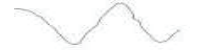

- Theta

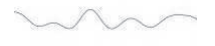

- Alpha

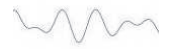

- Beta

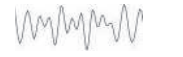

- Gamma

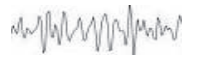

The first 3 wave types are observed from subjects asleep or relaxed. However, Beta and Gamma waves are observed during stimulation of senses and alertness / integration of sensory input, respectively.

We can see a significant difference in the frequency of these wavetypes, which we will base our research on. Most benchmark models make use of pooling types that significantly abstractify EEG waves. Therefore, we will attempt to develop a more sophisticated pooling type that will consider the frequency of these signals.

## **Methodology**

Our model's layers derive from EEGNet's and will thus not require any preprocessing of the dataset.

To incorporate the frequency of EEG waves in our model, we want to use a pooling type that can represent the critical points of a signal. However, Pytorch does not provide such pooling types. We will thus have to design and write our own.

We first considered using the variance of the signals as a measure of frequency. Pytorch offers torch.std which calculates the standard deviation of a tensor. We used this metric for our first model implementation.


In [2]:
%%file models/Model1.py

import torch
import speechbrain as sb

import torch
import torch.nn as nn

class StdDevPooling2D(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, pool_axis=[1,2]):
        super(StdDevPooling2D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding
        self.pool_axis = pool_axis

    def forward(self, x):
        #reshape x to have strides of kernel_size
        x = x.unfold(3, self.kernel_size[0], self.stride[0]).unfold(3, self.kernel_size[1], self.stride[1])
        #calculate std
        x = torch.std(x, dim=self.pool_axis)
        return x

Writing models/Model1.py


Because of the volatile nature of EEG signals, we fear that the standard deviation of a signal contains too much noise to produce significant results. Therefore, we also implemented an identical model that uses max-min difference pooling.

In [3]:
%%file models/Model2.py

import torch
import speechbrain as sb

import torch
import torch.nn as nn

class MaxMinDifferencePooling2d(nn.Module):
    def __init__(self, kernel_size, stride=None, pool_axis=[1,2]):
        super(MaxMinDifferencePooling2d, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size, stride=stride)
        self.min_pool = nn.MaxPool2d(kernel_size, stride=stride)
        self.pool_axis = pool_axis

    def forward(self, x):
        x = (
            x.unsqueeze(-1)
            .unsqueeze(-1)
            .transpose(-2, self.pool_axis[0])
            .transpose(-1, self.pool_axis[1])
            .squeeze(self.pool_axis[1])
            .squeeze(self.pool_axis[0])
        )
        max_output = self.max_pool(x)
        min_output = self.min_pool(-x)
        x = max_output + min_output
        x = (
            x.unsqueeze(self.pool_axis[0])
            .unsqueeze(self.pool_axis[1])
            .transpose(-2, self.pool_axis[0])
            .transpose(-1, self.pool_axis[1])
            .squeeze(-1)
            .squeeze(-1)
        )
        return x

Writing models/Model2.py


Inconveniently, not much research about different pooling types for EEG classification has been made, and we were therefore not able to draw on other studies.

Our final models will have the following structure

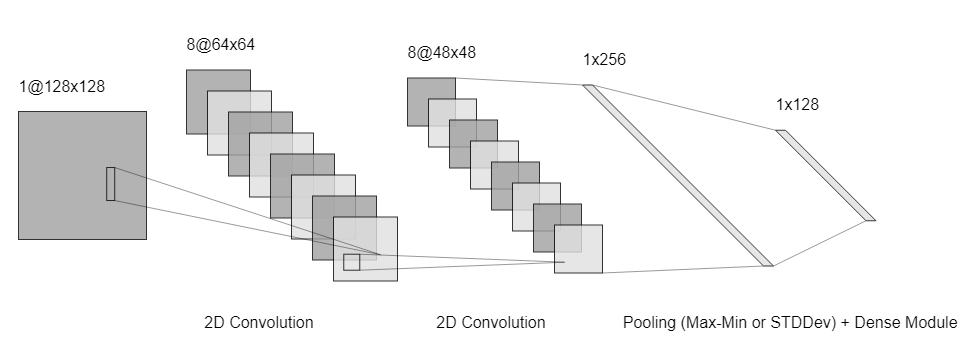

PS: The input size in the above diagram do not reflect the actual input size

## **Experimental Setup**

The dataset used for training and evaluating our model is the BNCI2014001 Motor Imagery dataset. The dataset consists of the EEG data from 9 subjects who each participated in 596 trials. A trial consisted of "imagining" movement of either the left hand, right hand, legs, or tongue.

Machine learning techniques used were mostly drawn from existing work.

- Batch normalization after every convolutional layer, since it has been shown to improve accuracy on most models and input data type [5].
- Leaky RELU activations after the final convolutional layer. Although many existing models used ELU activations, we chose LeakyRELU to keep a linear difference between values in feature maps (for our pooling type which looks at the difference between these values)
- Dropout after some layers to reduce overfitting. We referred to existing models to decide that a dropout rate of 50% would reduce overfitting the most effectively.
- Average pooling after every Max-Min pooling to generalize the difference between the Max and Min of EEG signals
- A Dense module derived from EEGNet, which consists of Flattening, Linearization, and a Logarithmic Softmax activation

The final models are written below:





In [4]:
%%file -a models/Model1.py

import torch
import speechbrain as sb

import torch
import torch.nn as nn
import torch.nn.functional as F

class StdDevPooling2D(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, pool_axis=[1,2]):
        super(StdDevPooling2D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding
        self.pool_axis = pool_axis

    def forward(self, x):
        #reshape x to have strides of kernel_size
        x = x.unfold(3, self.kernel_size[0], self.stride[0]).unfold(3, self.kernel_size[1], self.stride[1])
        #calculate std
        x = torch.std(x, dim=self.pool_axis)
        return x


class Model1(torch.nn.Module):
    """
    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    """

    def __init__(
        self,
        input_shape=None,  # (1, T, C, 1)
        cnn_temporal_kernels=8,
        cnn_temporal_kernelsize=(33, 1),
        cnn_spatial_depth_multiplier=2,
        cnn_spatial_pool=(4, 1),
        dropout=0.5,
        dense_max_norm=0.25,
        dense_n_neurons=4,
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        self.default_sf = 128
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="valid",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))

        cnn_spatial_kernels = (
            cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", torch.nn.LeakyReLU())
        self.conv_module.add_module(
            "pool_1",
            StdDevPooling2D(
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
            )
        )
        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)
        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.dense_module(x)
        return x



Appending to models/Model1.py


In [5]:
%%file -a models/Model2.py


import torch
import speechbrain as sb

import torch
import torch.nn as nn

class MaxMinDifferencePooling2d(nn.Module):
    def __init__(self, kernel_size, stride=None, pool_axis=[1,2]):
        super(MaxMinDifferencePooling2d, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size, stride=stride)
        self.min_pool = nn.MaxPool2d(kernel_size, stride=stride)
        self.pool_axis = pool_axis

    def forward(self, x):
        x = (
            x.unsqueeze(-1)
            .unsqueeze(-1)
            .transpose(-2, self.pool_axis[0])
            .transpose(-1, self.pool_axis[1])
            .squeeze(self.pool_axis[1])
            .squeeze(self.pool_axis[0])
        )
        max_output = self.max_pool(x)
        min_output = self.min_pool(-x)
        x = max_output + min_output
        x = (
            x.unsqueeze(self.pool_axis[0])
            .unsqueeze(self.pool_axis[1])
            .transpose(-2, self.pool_axis[0])
            .transpose(-1, self.pool_axis[1])
            .squeeze(-1)
            .squeeze(-1)
        )
        return x

class Model2(torch.nn.Module):
    """
    Arguments
    ---------
    input_shape: tuple
        The shape of the input.
    cnn_temporal_kernels: int
        Number of kernels in the 2d temporal convolution.
    cnn_temporal_kernelsize: tuple
        Kernel size of the 2d temporal convolution.
    cnn_spatial_depth_multiplier: int
        Depth multiplier of the 2d spatial depthwise convolution.
    cnn_spatial_max_norm: float
        Kernel max norm of the 2d spatial depthwise convolution.
    cnn_spatial_pool: tuple
        Pool size and stride after the 2d spatial depthwise convolution.
    dropout: float
        Dropout probability.
    dense_max_norm: float
        Weight max norm of the fully-connected layer.
    dense_n_neurons: int
        Number of output neurons.
    """

    def __init__(
        self,
        input_shape=None,  # (1, T, C, 1)
        cnn_temporal_kernels=8,
        cnn_temporal_kernelsize=(33, 1),
        cnn_spatial_depth_multiplier=2,
        cnn_spatial_pool=(4, 1),
        dropout=0.5,
        dense_max_norm=0.25,
        dense_n_neurons=4,
    ):
        super().__init__()
        if input_shape is None:
            raise ValueError("Must specify input_shape")
        self.default_sf = 128
        T = input_shape[1]
        C = input_shape[2]

        # CONVOLUTIONAL MODULE
        self.conv_module = torch.nn.Sequential()
        self.conv_module.add_module(
            "conv_0",
            sb.nnet.CNN.Conv2d(
                in_channels=1,
                out_channels=cnn_temporal_kernels,
                kernel_size=cnn_temporal_kernelsize,
                padding="valid",
                bias=False,
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_0",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_temporal_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("dropout_1", torch.nn.Dropout(p=dropout))


        cnn_spatial_kernels = (
            cnn_spatial_depth_multiplier * cnn_temporal_kernels
        )
        self.conv_module.add_module(
            "conv_1",
            sb.nnet.CNN.Conv2d(
                in_channels=cnn_temporal_kernels,
                out_channels=cnn_spatial_kernels,
                kernel_size=(1, C),
                groups=cnn_temporal_kernels,
                padding="valid",
                swap=True,
            ),
        )
        self.conv_module.add_module(
            "bnorm_1",
            sb.nnet.normalization.BatchNorm2d(
                input_size=cnn_spatial_kernels, momentum=0.01, affine=True,
            ),
        )
        self.conv_module.add_module("act_1", torch.nn.LeakyReLU())
        self.conv_module.add_module(
            "pool_1",
            MaxMinDifferencePooling2d(
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
            )
        )
        self.conv_module.add_module(
            "pool_2",
            sb.nnet.pooling.Pooling2d(
                pool_type='avg',
                kernel_size=cnn_spatial_pool,
                stride=cnn_spatial_pool,
                pool_axis=[1, 2],
            ),
        )

        out = self.conv_module(
            torch.ones((1,) + tuple(input_shape[1:-1]) + (1,))
        )
        dense_input_size = self._num_flat_features(out)

        # DENSE MODULE
        self.dense_module = torch.nn.Sequential()
        self.dense_module.add_module(
            "flatten", torch.nn.Flatten(),
        )
        self.dense_module.add_module(
            "fc_out",
            sb.nnet.linear.Linear(
                input_size=dense_input_size,
                n_neurons=dense_n_neurons,
                max_norm=dense_max_norm,
            ),
        )
        self.dense_module.add_module("act_out", torch.nn.LogSoftmax(dim=1))

    def _num_flat_features(self, x):
        """Returns the number of flattened features from a tensor.

        Arguments
        ---------
        x : torch.Tensor
            Input feature map.
        """

        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        """Returns the output of the model.

        Arguments
        ---------
        x : torch.Tensor (batch, time, EEG channel, channel)
            Input to convolve. 4d tensors are expected.
        """
        x = self.conv_module(x)
        x = self.dense_module(x)
        return x


Appending to models/Model2.py



As our model derives from EEGNet, we decided to use a modified version of its optimized hyperparameters as our starting point.

We then performed hyperparameter tuning on the model to obtain the following hyperparameters for Model 1


In [6]:
%%file hparams/MotorImagery/BNCI2014001/Model1.yaml

seed: 2024
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 3.2
fmax: 22.7
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 3.0
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 3
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 14
number_of_epochs: 443
lr: 0.0005
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 4
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 5
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.1858
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 5.1
snr_white_delta: 9.42
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 37
cnn_temporal_kernelsize: 29
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 3
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
max_cnn_spatial_pool: 4
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.3846

model: !new:models.Model1.Model1
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>


Writing hparams/MotorImagery/BNCI2014001/Model1.yaml


And the following hyperparameters for Model 2

In [7]:
%%file hparams/MotorImagery/BNCI2014001/Model2.yaml

seed: 2024
__set_torchseed: !apply:torch.manual_seed [!ref <seed>]

# DIRECTORIES
data_folder: !PLACEHOLDER  #'/path/to/dataset'. The dataset will be automatically downloaded in this folder
cached_data_folder: !PLACEHOLDER #'path/to/pickled/dataset'
output_folder: !PLACEHOLDER #'path/to/results'

# DATASET HPARS
# Defining the MOABB dataset.
dataset: !new:moabb.datasets.BNCI2014001
save_prepared_dataset: True # set to True if you want to save the prepared dataset as a pkl file to load and use afterwards
data_iterator_name: !PLACEHOLDER
target_subject_idx: !PLACEHOLDER
target_session_idx: !PLACEHOLDER
events_to_load: null # all events will be loaded
original_sample_rate: 250 # Original sampling rate provided by dataset authors
sample_rate: 125 # Target sampling rate (Hz)
# band-pass filtering cut-off frequencies
fmin: 0.13
fmax: 30.1
n_classes: 4
# tmin, tmax respect to stimulus onset that define the interval attribute of the dataset class
# trial begins (0 s), cue (2 s, 1.25 s long); each trial is 6 s long
# dataset interval starts from 2
# -->tmin tmax are referred to this start value (e.g., tmin=0.5 corresponds to 2.5 s)
tmin: 0.
tmax: 2.5
# number of steps used when selecting adjacent channels from a seed channel (default at Cz)
n_steps_channel_selection: 3
T: !apply:math.ceil
    - !ref <sample_rate> * (<tmax> - <tmin>)
C: 22
# We here specify how to perfom test:
# - If test_with: 'last' we perform test with the latest model.
# - if test_with: 'best, we perform test with the best model (according to the metric specified in test_key)
# The variable avg_models can be used to average the parameters of the last (or best) N saved models before testing.
# This can have a regularization effect. If avg_models: 1, the last (or best) model is used directly.
test_with: 'last' # 'last' or 'best'
test_key: "acc" # Possible opts: "loss", "f1", "auc", "acc"

# METRICS
f1: !name:sklearn.metrics.f1_score
    average: 'macro'
acc: !name:sklearn.metrics.balanced_accuracy_score
cm: !name:sklearn.metrics.confusion_matrix
metrics:
    f1: !ref <f1>
    acc: !ref <acc>
    cm: !ref <cm>
# TRAINING HPARS
n_train_examples: 100  # it will be replaced in the train script
# checkpoints to average
avg_models: 7
number_of_epochs: 965
lr: 0.001
# Learning rate scheduling (cyclic learning rate is used here)
max_lr: !ref <lr> # Upper bound of the cycle (max value of the lr)
base_lr: 0.00000001 # Lower bound in the cycle (min value of the lr)
step_size_multiplier: 5 #from 2 to 8
step_size: !apply:round
    - !ref <step_size_multiplier> * <n_train_examples> / <batch_size>
lr_annealing: !new:speechbrain.nnet.schedulers.CyclicLRScheduler
    base_lr: !ref <base_lr>
    max_lr: !ref <max_lr>
    step_size: !ref <step_size>
label_smoothing: 0.0
loss: !name:speechbrain.nnet.losses.nll_loss
    label_smoothing: !ref <label_smoothing>
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter  # epoch counter
    limit: !ref <number_of_epochs>
batch_size_exponent: 5
batch_size: !ref 2 ** <batch_size_exponent>
valid_ratio: 0.2

# DATA AUGMENTATION
# cutcat (disabled when min_num_segments=max_num_segments=1)
max_num_segments: 4
cutcat: !new:speechbrain.augment.time_domain.CutCat
    min_num_segments: 2
    max_num_segments: !ref <max_num_segments>
# random amplitude gain between 0.5-1.5 uV (disabled when amp_delta=0.)
amp_delta: 0.1405
rand_amp: !new:speechbrain.augment.time_domain.RandAmp
    amp_low: !ref 1 - <amp_delta>
    amp_high: !ref 1 + <amp_delta>
# random shifts between -300 ms to 300 ms (disabled when shift_delta=0.)
shift_delta_: 1 # orion_step2: --shift_delta_~"uniform(0, 25, discrete=True)"
shift_delta: !ref 1e-2 * <shift_delta_> # 0.250 # 0.-0.25 with steps of 0.01
min_shift: !apply:math.floor
    - !ref 0 - <sample_rate> * <shift_delta>
max_shift: !apply:math.floor
    - !ref 0 + <sample_rate> * <shift_delta>
time_shift: !new:speechbrain.augment.freq_domain.RandomShift
    min_shift: !ref <min_shift>
    max_shift: !ref <max_shift>
    dim: 1
# injection of gaussian white noise
snr_white_low: 11.0
snr_white_delta: 7.27
snr_white_high: !ref <snr_white_low> + <snr_white_delta>
add_noise_white: !new:speechbrain.augment.time_domain.AddNoise
    snr_low: !ref <snr_white_low>
    snr_high: !ref <snr_white_high>

repeat_augment: 1 # @orion_step1: --repeat_augment 0
augment: !new:speechbrain.augment.augmenter.Augmenter
    parallel_augment: True
    concat_original: True
    parallel_augment_fixed_bs: True
    repeat_augment: !ref <repeat_augment>
    shuffle_augmentations: True
    min_augmentations: 4
    max_augmentations: 4
    augmentations: [
        !ref <cutcat>,
        !ref <rand_amp>,
        !ref <time_shift>,
        !ref <add_noise_white>]

# DATA NORMALIZATION
dims_to_normalize: 1 # 1 (time) or 2 (EEG channels)
normalize: !name:speechbrain.processing.signal_processing.mean_std_norm
    dims: !ref <dims_to_normalize>
# MODEL
input_shape: [null, !ref <T>, !ref <C>, null]
cnn_temporal_kernels: 63
cnn_temporal_kernelsize: 27
# depth multiplier for the spatial depthwise conv. layer
cnn_spatial_depth_multiplier: 3
cnn_spatial_max_norm: 1.  # kernel max-norm constaint of the spatial depthwise conv. layer
cnn_spatial_pool: 4
max_cnn_spatial_pool: 4
dense_max_norm: 0.25  # kernel max-norm constaint of the dense layer
dropout: 0.01947

model: !new:models.Model2.Model2
    input_shape: !ref <input_shape>
    cnn_temporal_kernels: !ref <cnn_temporal_kernels>
    cnn_temporal_kernelsize: [!ref <cnn_temporal_kernelsize>, 1]
    cnn_spatial_depth_multiplier: !ref <cnn_spatial_depth_multiplier>
    cnn_spatial_pool: [!ref <cnn_spatial_pool>, 1]
    dense_max_norm: !ref <dense_max_norm>
    dropout: !ref <dropout>
    dense_n_neurons: !ref <n_classes>


Writing hparams/MotorImagery/BNCI2014001/Model2.yaml


Despite the numerous hyperparameters, the more important ones can be narrowed down to a set few:

- cnn_temporal_kernels: Will determine the number of kernels in the first (temporal) convolutional layer. Has been shown to have a significant effect on accuracy of benchmark models [4]

- cnn_temporal_kernelsize: Much like the cnn_temporal_kernels hyperparameter, has noticeable effects on accuracy. A larger kernel size will cause broader time dependencies to be considered, but might cause loss of resolution (blending patterns) [3].

- cnn_spatial_depth_multiplier: Determines the number of spatial kernels.



Having our 2 models set up, we can run a representative experiment on both to have a general idea of their performance

For the representative experiment, we will evaluate the models against data from 1 session of Subject 0

For Model 1

In [ ]:
!./run_experiments.sh --hparams hparams/MotorImagery/BNCI2014001/Model1.yaml --data_folder eeg_data --output_folder results/MotorImagery/BNCI2014001/Model1 --nsbj 1 --nsess 1 --nruns 1 --train_mode leave-one-session-out --device 'cuda'

For Model 2

In [ ]:
!./run_experiments.sh --hparams hparams/MotorImagery/BNCI2014001/Model2.yaml --data_folder eeg_data --output_folder results/MotorImagery/BNCI2014001/Model2 --nsbj 1 --nsess 1 --nruns 1 --train_mode leave-one-session-out --device 'cuda'

We obtain the following accuracies:

- Model 1: 0.590278

- Model 2: 0.798611

## **Experimental Results**
Given that Model 2 visibly outperforms Model 1 for Subject 0, we can safely assume that it is the better model.

The main experimental result for Model 2 can be obtained by running the following command

In [ ]:
!./run_experiments.sh --hparams hparams/MotorImagery/BNCI2014001/Model2.yaml --data_folder eeg_data --output_folder results/MotorImagery/BNCI2014001/Model2 --nsbj 9 --nsess 2 --nruns 1 --train_mode leave-one-session-out --device 'cuda'

Streaming output truncated to the last 5000 lines.
 [ 1  0 12  1]
 [ 1  4  2  7]]
speechbrain.utils.epoch_loop - Going into epoch 922
speechbrain.nnet.schedulers - Changing lr from 0.00089 to 0.00092
speechbrain.utils.train_logger - epoch: 922, lr: 8.61e-04 - train loss: 1.22e-01 - valid loss: 9.57e-01, valid f1: 6.35e-01, valid acc: 6.43e-01, valid cm: [[11  0  0  3]
 [ 2  6  1  5]
 [ 2  2  7  3]
 [ 1  1  0 12]]
speechbrain.utils.epoch_loop - Going into epoch 923
speechbrain.nnet.schedulers - Changing lr from 0.00089 to 0.00086
speechbrain.utils.train_logger - epoch: 923, lr: 9.17e-04 - train loss: 1.45e-01 - valid loss: 8.37e-01, valid f1: 7.52e-01, valid acc: 7.50e-01, valid cm: [[11  2  0  1]
 [ 2  9  1  2]
 [ 1  1 11  1]
 [ 1  2  0 11]]
speechbrain.utils.epoch_loop - Going into epoch 924
speechbrain.nnet.schedulers - Changing lr from 0.00067 to 0.00064
speechbrain.utils.train_logger - epoch: 924, lr: 6.94e-04 - train loss: 1.34e-01 - valid loss: 1.14, valid f1: 5.78e-01, valid acc

The overall accuracy is thus 76.25%

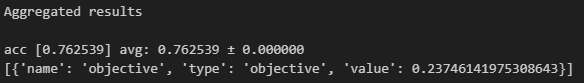

We notice that Model 2 is able to score a slightly higher accuracy than EEGNet.

Despite the satisfactory performance of Model 2, we do notice it does not perform as well for some subjects (e.g. Subject 0). This indicates the potential instability of the Variance metric

However, looking at the logs, we can see that EEGNet requires 145.9K trainable parameters whilst our Model 2 only has 19.4K. This significant difference in parameters does indicate a potential relevance of Variance metric in EEG signals classification.

Furthermore, the greater accuracy of Model 2 does agree with our initial assumption that networks with 2 convolutional layers can perform as well as deeper neural network.

We can also graph the loss over the epochs for both Model 2 and EEGNet to compare.

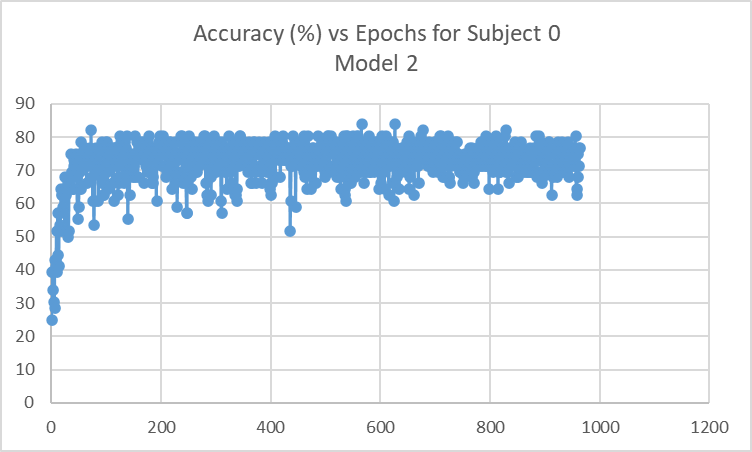

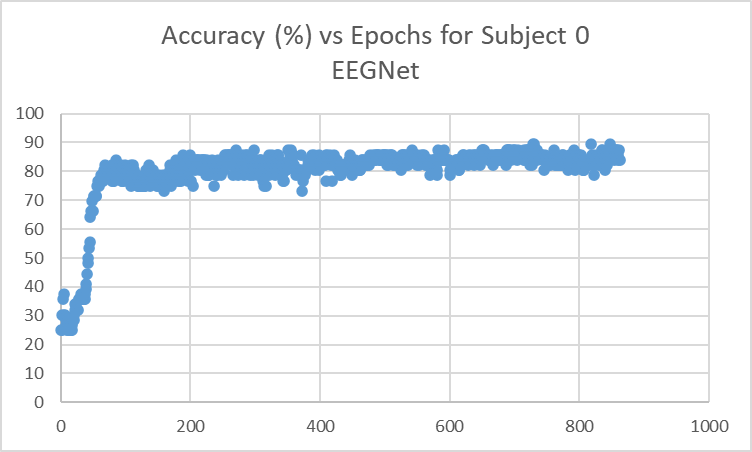


Though Model 2 converges rather quickly, we notice that the accuracy greatly varies throughout the epochs. We believe this variation is due to the unstable nature of the Max-Min metric. A possible modification of this metric would be the square root of Max-Min difference, which might be more stable.

Additionally, the Standard Deviation model did not perform as well as expected. As stated earlier, the Standard Deviation of EEG signals is bound to produce too much noise (because of the signals' volatility). By consequence, the metric itself is not reliable for pooling, unlike its less noisy counterpart (Max-Min difference)



## **Conclusions**

In this project, we conducted an extensive exploration of neural network architectures for decoding Motor Imagery from EEG data, focusing on the BNCI2014001 dataset and utilizing the SpeechBrain-MOBB library. Our experiments yielded several key findings:

- Model 2, that utilized Max-Min Difference pooling, was able to match EEGNet with less parameters. Therefore, Max-Min difference could be a relevant metric to consider in EEG signal classification. Though used in pooling in this research, we could consider applying it through other means into a model, such as with batch normalization, or as input to the NN.

- The Standard Deviation Model, in contrast, did not perform as well as expected. As stated in the introduction, we hypothesize that the inherently high volatility of EEG signals created too much noise, and rendered the metric unreliable for pooling. This highlights the importance of using less noisy metrics, such as Max-Min difference, for EEG signal analysis.



## **References**

[1] A. Subasi and E. Erçelebi, “Classification of EEG signals using neural network and logistic regression,” Computer Methods and Programs in Biomedicine, vol. 78, no. 2, pp. 87–99, May 2005. doi:10.1016/j.cmpb.2004.10.009

[2] A. Antoniades, L. Spyrou, C. C. Took, and S. Sanei, “Deep learning for epileptic intracranial EEG Data,” 2016 IEEE 26th International Workshop on Machine Learning for Signal Processing (MLSP), Sep. 2016. doi:10.1109/mlsp.2016.7738824

[3] K. H. Cheah, H. Nisar, V. V. Yap, C.-Y. Lee, and G. R. Sinha, “Optimizing residual networks and VGG for classification of EEG signals: Identifying ideal channels for emotion recognition,” Journal of Healthcare Engineering, vol. 2021, pp. 1–14, Mar. 2021. doi:10.1155/2021/5599615

[4] E. Arı and E. Taçgın, “Input shape effect on classification performance of raw EEG motor imagery signals with convolutional neural networks for use in brain—computer interfaces,” Brain Sciences, vol. 13, no. 2, p. 240, Jan. 2023. doi:10.3390/brainsci13020240

[5] J. Bjorck, C. Gomes, B. Selman, and K. Q. Weinberger, “Understanding batch normalization,” arXiv.org, https://arxiv.org/abs/1806.02375 (accessed Apr. 16, 2024).